# Benchmark for Community detection

In [121]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import locally_popular_clustering_with_hop_distance, extract_labels_from_communities, time_tester, calculate_scores_CD

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_node_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity


import data.jazz as jazz
import data.cora as cora

## Create Graphs

In [122]:
repetitions = 1    #Number of random isomorph permutation for each graph

cora_graph = cora.get_graph()

cora_graph = nx.relabel_nodes(cora_graph, {list(cora_graph.nodes())[i] : i for i in range(len(cora_graph.nodes()))} )
cora_truth = list(cora_graph.nodes[i]['subject'] for i in range(len(cora_graph.nodes())))
cora_perm_graph = []
cora_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(cora_graph,cora_truth)
    cora_perm_graph += [g]
    cora_perm_truth += [t]


jazz_graph = jazz.get_graph()
jazz_graph = nx.relabel_nodes(jazz_graph, {i : i-1 for i in range(len(jazz_graph)+1)} )
jazz_graph,_ = randomize_graph_node_labels(jazz_graph,None)
jazz_truth = None

jazz_perm_graph = []
jazz_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(jazz_graph,jazz_truth)
    jazz_perm_graph += [g]
    jazz_perm_truth += [t]


karate_graph = nx.karate_club_graph()
#karate_graph,_ = randomize_graph_node_labels(karate_graph,None)
karate_truth = list(karate_graph.nodes[i]["club"] for i in range(34))

karate_perm_graph = []
karate_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(karate_graph,karate_truth)
    karate_perm_graph += [g]
    karate_perm_truth += [t]

karate_perm_graph = [karate_graph,karate_graph,karate_graph,karate_graph,karate_graph]
karate_perm_truth = [karate_truth,karate_truth,karate_truth,karate_truth,karate_truth]

graph,graph_truth = generate_graph(10,25,0.2,0.05)

graph_perm_graph = []
graph_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(graph,graph_truth)
    graph_perm_graph += [g]
    graph_perm_truth += [t]




## Run the algorithms


## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [125]:
import itertools
import timeit 
import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2),(0.25,0.35), (0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(10):
        f = treshold[0]   #f-bound
        e = treshold[1]   
    
        
        
        graphs = [karate_perm_graph,cora_perm_graph,jazz_perm_graph,graph_perm_graph]
        expected_clusters = [2,7,None,25]
        graph_names = [ 'Karate Club','Cora','Jazz','25 random communities']
        graph_truths =  [karate_perm_truth,cora_perm_truth,jazz_perm_truth,graph_perm_truth]
        
        
        𝓗 = Modularity(1.0)
        
        fn_louvain_mod = lambda G,_: louvain(G, 𝓗)
        fn_leiden_mod  = lambda G,_: leiden(G, 𝓗)
        
        louv_out = None
        lei_out = None
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']
        
        lp_a_b =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='B',pre = pre)
        lp_a_f =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='F',pre = pre)
        lp_a_e =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='E',pre = pre)
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)','LP (Balanced) Heuristic',\
                       'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
        
        
        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
            
                
                
            agents = []
            for i in range(len(graph)):
                agents += [list(graph[i].nodes())]
        
        
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                initial_clusters = len(agents[0])
                if graph == cora_perm_graph:
                    a_name_modified += ' *6 starting clusters'
                    initial_clusters = 6
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                
                test_callable = lambda a: algo(a,initial_clusters,None)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                
                # starting with predicted number of clusters
                a_name_modified = a_name + ' starting with predicted number of clusters'
                initial_clusters = clusters
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                
                test_callable = lambda a: algo(a,initial_clusters,None)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                
                # start with the output of leiden
                a_name_modified = a_name + ' starting with the output of leiden'
                initial_clusters = clusters
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                
                test_callable = lambda a: algo(a,initial_clusters,fn_leiden_mod)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
        
                rand_score_with_init = sum(rand_score(list(out.values()), list(lei.values())) for out, lei in zip(outputs, lei_output)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
               
        
            else:
                print(f"Running {a_name} on {g_name} … ", end='')
                test_callable = lambda a : algo(a,_)
                times,outputs = time_tester(test_callable,graph)
                outputs = [extract_labels_from_communities(c.communities) for c in outputs]
        
                if algo == fn_leiden_mod:
                    lei_output = outputs
                    
                
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
    records = []
    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        # metrics_list is a list of 10 dictionaries
        keys = metrics_list[0].keys()
        for key in keys:
            # check if this metric is numeric
            if isinstance(metrics_list[0][key], numbers.Number):
                values = [m[key] for m in metrics_list]
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                # if not numeric (e.g., a string), just copy one of them
                record[key] = metrics_list[0][key]
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)

dfs[0].head()

Running Louvain (Mod) on Karate Club … execution time: ~ 0.008604 seconds.
Rand Index : ~ 0.6720142602495544
Modularity : ~ 0.44014355053316095
Time : ~ 0.008603920001769438
Running Leiden (Mod) on Karate Club … execution time: ~ 0.016661 seconds.
Rand Index : ~ 0.6549019607843138
Modularity : ~ 0.4418601600419782
Time : ~ 0.016660500009311362
Running LP (Balanced) Heuristic starting with everyone alone on Karate Club … execution time: ~ 0.011545 seconds.
Rand Index : ~ 0.5525846702317291
Modularity : ~ 0.20661157024793392
Time : ~ 0.011544640001375228
Running LP (Balanced) Heuristic starting with predicted number of clusters on Karate Club … execution time: ~ 0.003885 seconds.
Rand Index : ~ 0.5294117647058824
Modularity : ~ 0.2790708569929349
Time : ~ 0.003884779993677512
Running LP (Balanced) Heuristic starting with the output of leiden on Karate Club … execution time: ~ 0.021868 seconds.
Rand Index : ~ 0.704812834224599
Modularity : ~ 0.4293866306853319
Rand Score with initial clus

,Method,Dataset,Rand Index,Modularity,Time,Rand Score with initial clustering
0,Louvain (Mod),Karate Club,"(0.6737254901960785, 0.007335370352719667)","(0.4408365660313712, 0.002886993979204846)","(0.009008034000289626, 0.001340213097988923)",NaN
1,Leiden (Mod),Karate Club,"(0.6655971479500893, 0.009628308874003857)","(0.44088454114428133, 0.002554512814493067)","(0.019800168004003353, 0.0028492580736942347)",NaN
2,LP (Balanced) Heuristic starting with everyone...,Karate Club,"(0.5525846702317291, 0.0)","(0.20661157024793392, 0.0)","(0.01211478399927728, 0.0018725003288137727)",NaN
3,LP (Balanced) Heuristic starting with predicte...,Karate Club,"(0.5294117647058824, 0.0)","(0.2790708569929349, 0.0)","(0.003029653996345587, 0.0007538920066449768)",NaN
4,LP (Balanced) Heuristic starting with the outp...,Karate Club,"(0.7015329768270944, 0.0023038138212339966)","(0.4286741252975019, 0.0012340742456733095)","(0.023008584001800045, 0.0024393116796060602)","(0.6892691622103386, 0.004621399051151194)"


In [135]:
max_stds = {}

for df in dfs:
    for col in ['Rand Index']:
        stds = df[col].apply(lambda x: x[1] if isinstance(x, (tuple, list)) else float('nan'))
        max_stds[col] = max(max_stds.get(col, float('-inf')), stds.max())

print(max_stds)

{'Rand Index': 0.02724566131010166}


In [136]:
dfs[0]

,Method,Dataset,Rand Index,Modularity,Time,Rand Score with initial clustering,Threshold
0,Louvain (Mod),Karate Club,"(0.6737254901960785, 0.007335370352719667)","(0.4408365660313712, 0.002886993979204846)","(0.009008034000289626, 0.001340213097988923)",NaN,"(0.2, 0.2)"
1,Leiden (Mod),Karate Club,"(0.6655971479500893, 0.009628308874003857)","(0.44088454114428133, 0.002554512814493067)","(0.019800168004003353, 0.0028492580736942347)",NaN,"(0.2, 0.2)"
2,LP (Balanced) Heuristic starting with everyone...,Karate Club,"(0.5525846702317291, 0.0)","(0.20661157024793392, 0.0)","(0.01211478399927728, 0.0018725003288137727)",NaN,"(0.2, 0.2)"
3,LP (Balanced) Heuristic starting with predicte...,Karate Club,"(0.5294117647058824, 0.0)","(0.2790708569929349, 0.0)","(0.003029653996345587, 0.0007538920066449768)",NaN,"(0.2, 0.2)"
4,LP (Balanced) Heuristic starting with the outp...,Karate Club,"(0.7015329768270944, 0.0023038138212339966)","(0.4286741252975019, 0.0012340742456733095)","(0.023008584001800045, 0.0024393116796060602)","(0.6892691622103386, 0.004621399051151194)","(0.2, 0.2)"
5,LP (Friend-Oriented) Heuristic starting with e...,Karate Club,"(0.5597147950089126, 0.0)","(0.26007758475290943, 0.0)","(0.012681894006091172, 0.002054178689912956)",NaN,"(0.2, 0.2)"
6,LP (Friend-Oriented) Heuristic starting with p...,Karate Club,"(0.5294117647058824, 0.0)","(0.2790708569929349, 0.0)","(0.0029870020021917298, 0.0007181670394235312)",NaN,"(0.2, 0.2)"
7,LP (Friend-Oriented) Heuristic starting with t...,Karate Club,"(0.702245989304813, 0.003239306008299617)","(0.4287936882742077, 0.0011413082539445544)","(0.02080778799892869, 0.0024242060110936463)","(0.6888413547237077, 0.004354049095407386)","(0.2, 0.2)"
8,LP (Enemy-Averse) Heuristic starting with ever...,Karate Club,"(0.5525846702317291, 0.0)","(0.20661157024793392, 0.0)","(0.010503832001122645, 0.0022307479195568356)",NaN,"(0.2, 0.2)"
9,LP (Enemy-Averse) Heuristic starting with pred...,Karate Club,"(0.5294117647058824, 0.0)","(0.2790708569929349, 0.0)","(0.0029527800012147053, 0.000690461224900827)",NaN,"(0.2, 0.2)"


In [139]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

def plot_custom_thresholds_with_louvain_leiden(dfs, labels, dataset_name, score_col='Rand Index'):
    # Add threshold column to each DataFrame
    for df, label in zip(dfs, labels):
        df['Threshold'] = str(label)  # make sure label is string for plotting

    # Combine all datasets
    df_all = pd.concat(dfs)

    # Filter for selected dataset
    df_all = df_all[df_all['Dataset'] == dataset_name].copy()

    # Add method group
    def method_group(row):
        m = row['Method']
        if 'everyone alone' in m:
            return 'LocPop with everyone alone'
        elif 'predicted number of clusters' in m:
            return 'LocPop with predicted number of clusters'
        elif 'output of leiden' in m:
            return 'LocPop with Leiden output'
        elif 'louvain' in m.lower():
            return 'Louvain'
        elif 'leiden' in m.lower():
            return 'Leiden'
        else:
            return 'Other'

    def variant_label(row):
        m = row['Method']
        if 'Enemy-Averse' in m:
            return 'Enemy-Averse'
        elif 'Balanced' in m:
            return 'Balanced'
        elif 'Friend-Oriented' in m:
            return 'Friend-Oriented'
        else:
            return 'Other'

    df_all['method_group'] = df_all.apply(method_group, axis=1)
    df_all['variant'] = df_all.apply(variant_label, axis=1)

    # Define order and positions
    method_order = ['Louvain', 'Leiden', 'LocPop with everyone alone', 'LocPop with predicted number of clusters',
                    'LocPop with Leiden output']
    method_pos = {method: i for i, method in enumerate(method_order)}

    variant_colors = {
        'Balanced': 'green',
        'Friend-Oriented': 'orange',
        'Enemy-Averse': 'blue'
    }
    threshold_markers = {
        str(labels[0]): '^',
        str(labels[1]): 'o',
        str(labels[2]): 's'
    }
    variant_offset = {
        'Friend-Oriented': -0.2,
        'Balanced': 0.0,
        'Enemy-Averse': 0.2
    }

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot LP heuristics
    for method in method_order[2:]:  # skip Leiden/Louvain
        for variant in ['Balanced', 'Friend-Oriented', 'Enemy-Averse']:
            for threshold in threshold_markers.keys():
                sub_df = df_all[
                    (df_all['method_group'] == method) &
                    (df_all['variant'] == variant) &
                    (df_all['Threshold'] == threshold)
                ]
                if sub_df.empty:
                    continue

                x_pos = method_pos[method] + variant_offset[variant] + 2
                means = sub_df[score_col].apply(lambda x: x[0]).values
                stds = sub_df[score_col].apply(lambda x: x[1]).values

                ax.scatter(
                    [x_pos] * len(means), means,
                    color=variant_colors[variant],
                    marker=threshold_markers[threshold],
                    s=80, edgecolor='black', alpha=0.8,
                    label=f'{variant} - {threshold}' if (threshold == str(labels[0])) else None
                )

                # Plot 2-sigma error bars
                for mean, std in zip(means, stds):
                    ax.plot(
                        [x_pos, x_pos],
                        [mean - 2*std, mean + 2*std],
                        color=variant_colors[variant],
                        alpha=0.4,
                        linewidth=1
                    )

    # Plot Leiden and Louvain averages
    for method in ['Leiden', 'Louvain']:
        if method not in method_pos:
            continue  # skip if method not recognized
    
        sub_df = df_all[df_all['method_group'] == method]
        if sub_df.empty or sub_df[score_col].isna().all():
            continue  # skip if no valid scores
    
        y_vals = [val[0] for val in sub_df[score_col].dropna().values]
        y_stds = [val[1] for val in sub_df[score_col].dropna().values]
    
        avg = np.mean(y_vals)
        std = np.sqrt(np.mean([s**2 for s in y_stds]))
    
        ax.scatter(
            method_pos[method] + 2, avg,
            color='black', marker='o', s=80, edgecolor='white',
            label=None
        )
    
        ax.errorbar(
            method_pos[method] + 2, avg,
            yerr=2*std,
            fmt='none',
            ecolor='black',
            elinewidth=1,
            capsize=3,
            alpha=0.6
        )

    ax.set_xticks(range(2, len(method_order)+2))
    ax.set_xticklabels(method_order, rotation=90)
    ax.set_ylabel(score_col)
    ax.set_title(f'{score_col} by Method on {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Color legend
    color_legend = [
        Line2D([0], [0], marker='o', color='w', label=v, markerfacecolor=c, markersize=10, markeredgecolor='black')
        for v, c in variant_colors.items()
    ]
    shape_legend = [
        Line2D([0], [0], marker=m, color='w', label=thresh, markerfacecolor='gray', markersize=10, markeredgecolor='black')
        for thresh, m in threshold_markers.items()
    ]

    # Adjust legend position
    plt.legend(
        handles=color_legend + shape_legend, 
        title='Variant / Threshold', 
        loc='upper left',
        bbox_to_anchor=(1.05, 1),
        borderaxespad=0.5,
        fontsize=10,
        ncol=1
    )
    plt.ylim(0,1.1)
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.subplots_adjust(right=0.75)

    return fig, ax


In [140]:
import numpy as np
labels = [(0.2, 0.2), (0.25, 0.35), (0.4, 0.4)]
def plot_and_save(dfs,labels, dataset, score, save_path= None):
    for df in dfs:
        df.replace("n.A.", np.nan, inplace= True)

    fig, ax = plot_custom_thresholds_with_louvain_leiden(
    dfs=dfs,
    labels=labels,
    dataset_name=dataset,
    score_col=score)
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Figure saved as {save_path}")
    plt.show()
def normalize_score_column(df, score_cols):
    for col in score_cols:
        df[col] = df[col].apply(lambda x: (x, 0) if isinstance(x, float) else x)
    return df



Figure saved as /Users/User/Downloads/local-popular-main-final/community/25 random communities-Rand Index.png


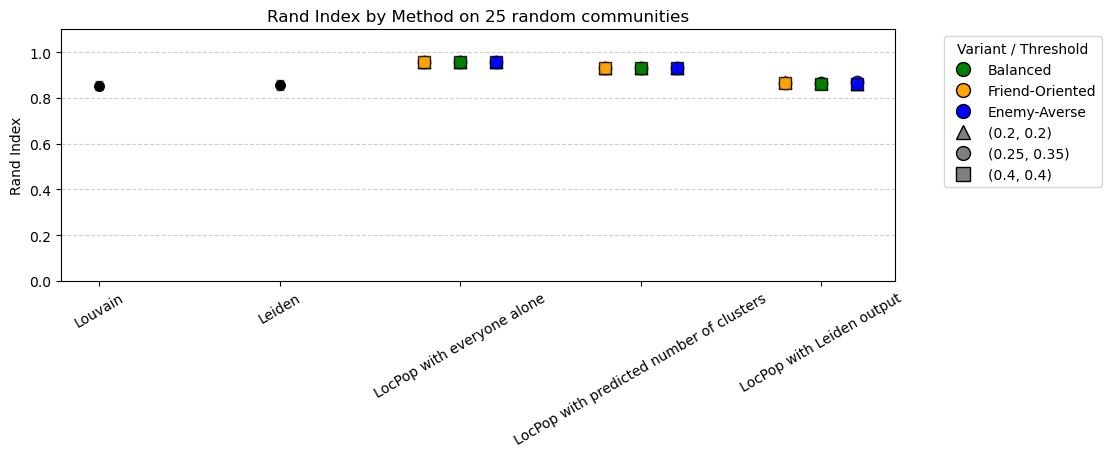

Figure saved as /Users/User/Downloads/local-popular-main-final/community/25 random communities-Modularity.png


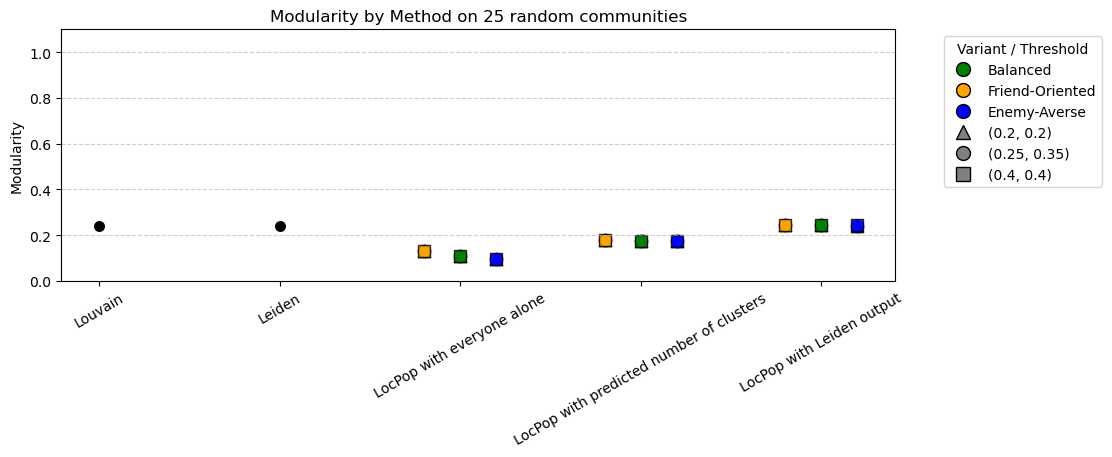

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Cora-Rand Index.png


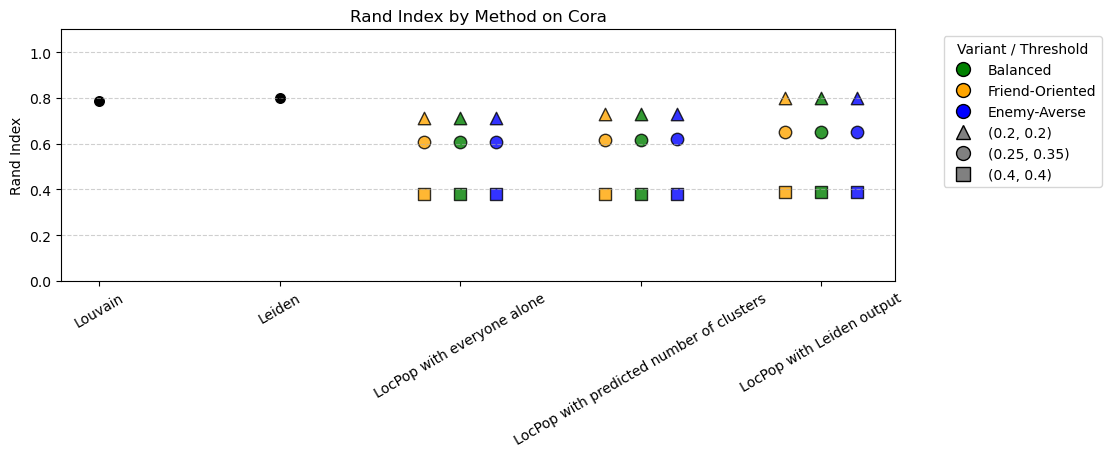

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Cora-Modularity.png


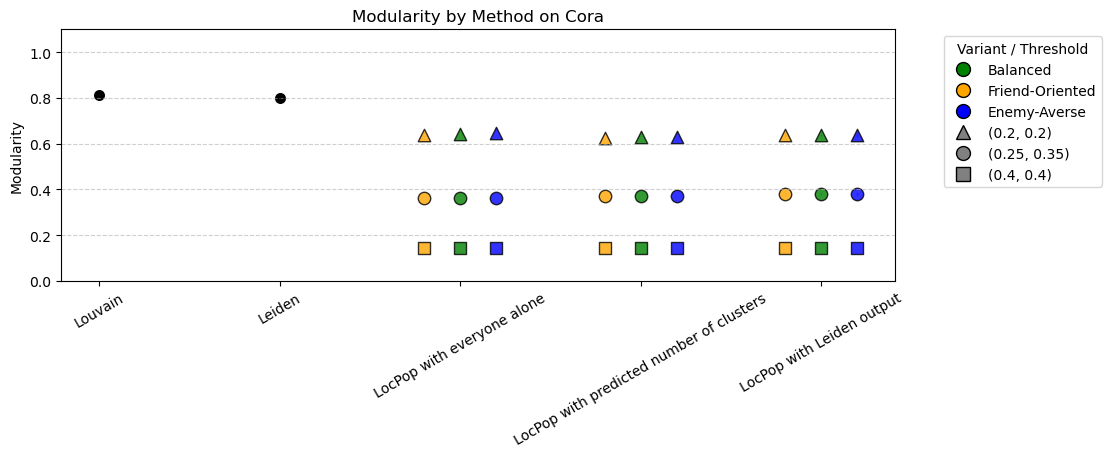

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Jazz-Rand Index.png


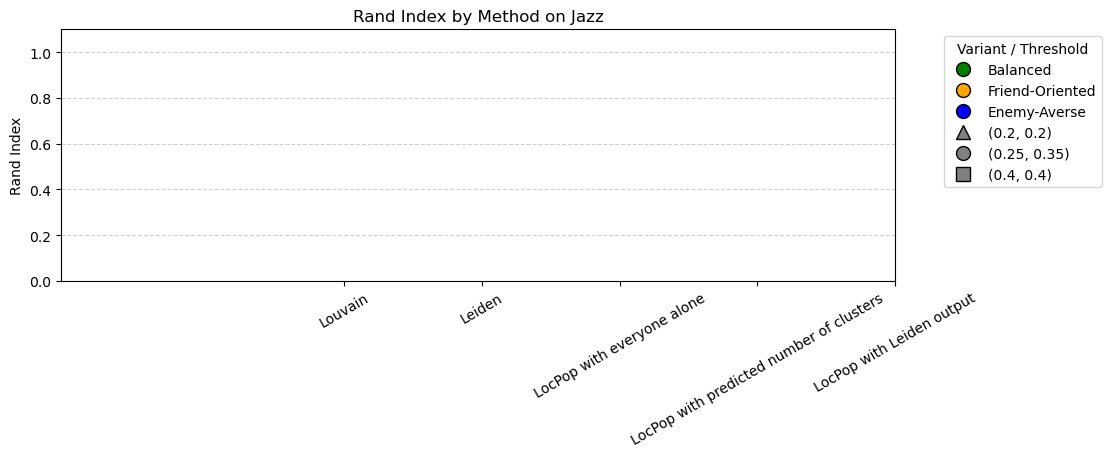

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Jazz-Modularity.png


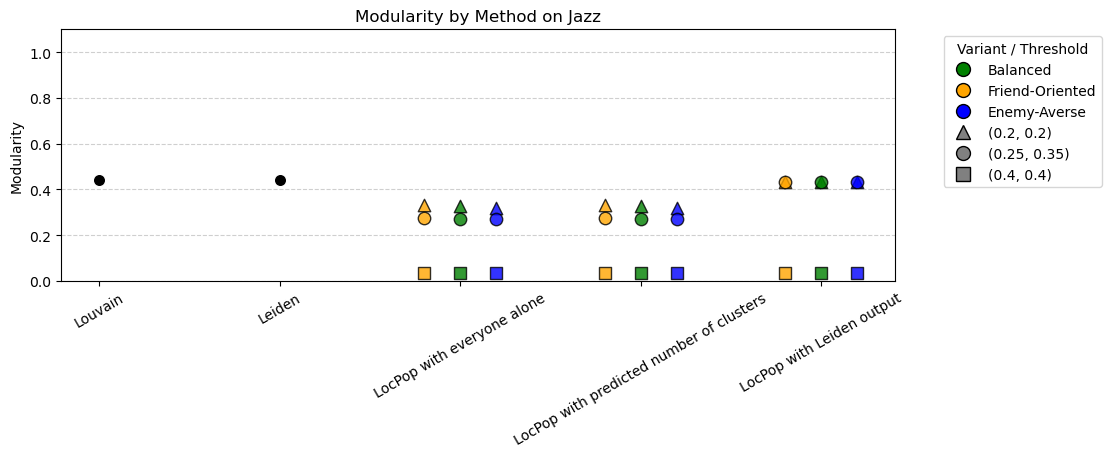

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Karate Club-Rand Index.png


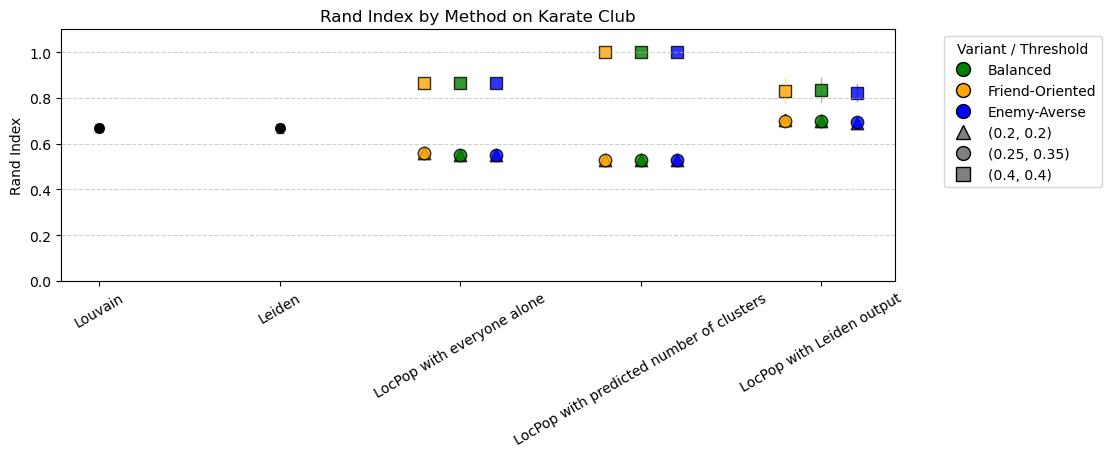

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Karate Club-Modularity.png


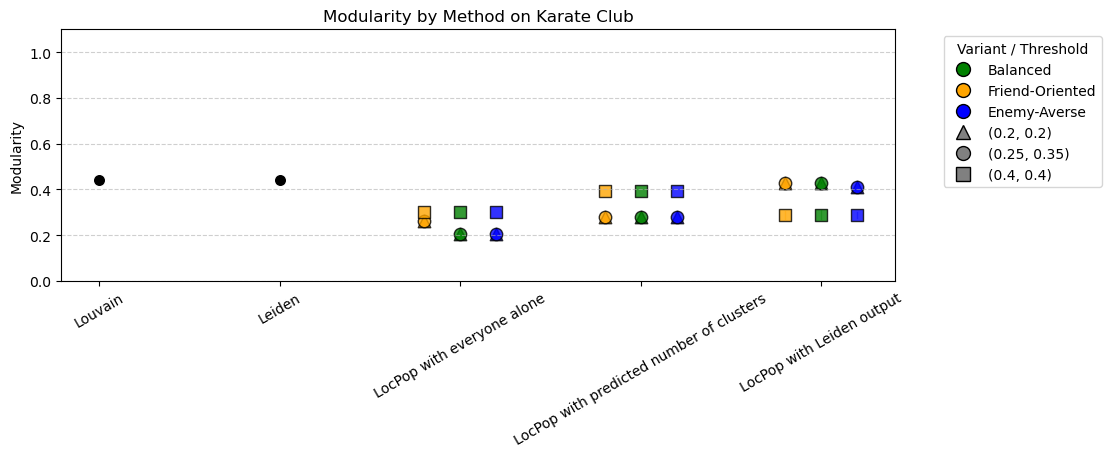

In [141]:
for df in dfs:
    df.replace("n.A.", np.nan, inplace=True)

score_cols = ['Rand Index', 'Modularity']
dfs = [normalize_score_column(df, score_cols) for df in dfs]

for Dataset in ['25 random communities', 'Cora' ,'Jazz' ,'Karate Club']:
    for score in ['Rand Index', 'Modularity']:
        plot_and_save(dfs,labels, Dataset, score, save_path=f'/Users/User/Downloads/local-popular-main-final/community/{Dataset}-{score}.png')
